## Семинар 9: "LSTM"[SOLVED]

ФИО:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from IPython.display import clear_output
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [30]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
        
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
    
        
        h, c = hidden
        bs = h.size(0)
        out_size = 1
        Linear = nn.Linear(bs * h.size(1), out_size)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        out = Linear(out.view(len(inputs), -1))
        return out[-1], (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

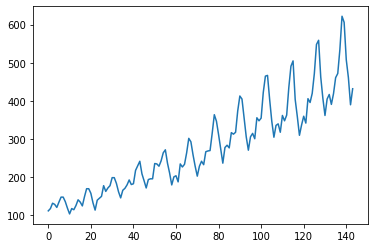

In [31]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [32]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [33]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [34]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [35]:
# Пример подготовленных данных

look_back = 5
look_forward=1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [36]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [37]:
train_dataset[0]

(tensor([[0.0154, 0.0270, 0.0541, 0.0483, 0.0328]]), tensor([0.0598]))

In [38]:
train_dataloader =  DataLoader(train_dataset, batch_size=1)

In [39]:
epochs = 100
seq_length = look_back
batch_size = 1
input_size = 1
hidden_size = 1
hidden = (torch.ones(batch_size, hidden_size),torch.zeros(batch_size, hidden_size))
koll_test = len(test)

model = LSTM(input_size, hidden_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)



In [40]:
koll_test


48

In [41]:
def train(epochs, seq_length, batch_size, train_dataloader, hidden):
    for i in range(epochs):
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.view(seq_length, batch_size)
            pred = model(X, hidden)
            loss = loss_function(pred[0][-1], y)
            loss.backward()
            optimizer.step()
        evald(seq_length, koll_test, train_dataset, dataset)
        
        if i%25 == 1:
            print(f'epoch: {i:3} loss: {loss.item():10.8f}')

In [51]:
def evald(seq_length, koll_test, train_dataset, dataset):
    dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
    test_inputs = train_dataset[-1, 0][0].tolist()
    model.eval()
    for j in range(koll_test):
        seq = torch.FloatTensor(test_inputs[-seq_length:]).view(seq_length, -1)
        with torch.no_grad():
            hidden = (torch.zeros(batch_size, hidden_size),
                            torch.zeros(batch_size, hidden_size))
            test_inputs.append(model(seq,hidden)[0][-1].item())
    
    actual_predictions = scaler.inverse_transform(np.array(test_inputs[seq_length:] ).reshape(-1, 1))
    x = np.arange(len(dataset) - koll_test - 1, len(dataset) - 1, 1)
    
    clear_output(True)
    plt.title('Month vs Passenger')
    plt.ylabel('Total Passengers')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(dataset)
    plt.plot(x,actual_predictions)
    plt.show()

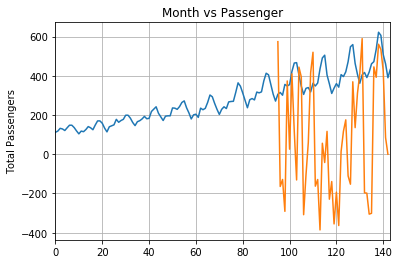

In [52]:
train(epochs, seq_length, batch_size, train_dataloader, hidden)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: